# 6.2 AnoGAN

In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generator

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


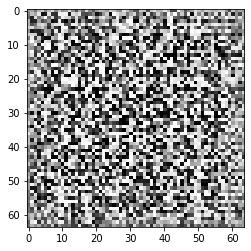

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminator

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out 
        feature = feature.view(feature.size()[0], -1)

        out = self.last(out)

        return out, feature


In [6]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out[0]))

print(d_out[1].shape)


tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


# DataLoader

In [7]:
def make_datapath_list():

    train_img_list = list() 
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [8]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [9]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path) 

        img_transformed = self.transform(img)

        return img_transformed


In [10]:
# DataLoader

train_img_list=make_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader) 
imges = next(batch_iterator)  
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [12]:

def train_model(G, D, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()  
    D.train() 

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    # epoch
    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch
        epoch_d_loss = 0.0  # epoch

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        for imges in dataloader:

            # --------------------
            # 1. Discriminator
            # --------------------
            if imges.size()[0] == 1:
                continue

            imges = imges.to(device)

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real, _ = D(imges)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator
            # --------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [13]:
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0689 ||Epoch_G_Loss:0.2649
timer:  1.7292 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0048 ||Epoch_G_Loss:0.5844
timer:  0.2884 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.2477 ||Epoch_G_Loss:0.6156
timer:  0.2732 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0400 ||Epoch_G_Loss:0.2153
timer:  0.2813 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0062 ||Epoch_G_Loss:0.4022
timer:  0.2722 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.2370 ||Epoch_G_Loss:0.4528
timer:  0.2725 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.1054
timer:  0.2803 sec.
-------------
Epoch 7/300
-------------
（train）
-------

-------------
epoch 60 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.1253
timer:  0.2742 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.1263 ||Epoch_G_Loss:0.1208
timer:  0.2788 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.1148 ||Epoch_G_Loss:0.1267
timer:  0.2720 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.1161 ||Epoch_G_Loss:0.1288
timer:  0.2772 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.1190 ||Epoch_G_Loss:0.1286
timer:  0.2729 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.1263 ||Epoch_G_Loss:0.1118
timer:  0.2740 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.1161 ||Epoch_G_Loss:0.1447
timer:  0.2709 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0794 ||Epoch_G_Loss:0.1957
timer:  0.2943 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.2058
timer:  0.2802 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.1804
timer:  0.2798 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0786 ||Epoch_G_Loss:0.2026
timer:  0.2790 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0972 ||Epoch_G_Loss:0.2113
timer:  0.2816 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0607 ||Epoch_G_Loss:0.2072
timer:  0.2736 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0908 ||Epoch_G_Loss:0.2172
timer:  0.2847 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0401 ||Epoch_G_Loss:0.3072
timer:  0.2885 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0518 ||Epoch_G_Loss:0.3102
timer:  0.2743 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0289 ||Epoch_G_Loss:0.3492
timer:  0.2746 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.3039
timer:  0.2739 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0424 ||Epoch_G_Loss:0.3551
timer:  0.2757 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0668 ||Epoch_G_Loss:0.3066
timer:  0.2798 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0315 ||Epoch_G_Loss:0.3228
timer:  0.2732 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0369 ||Epoch_G_Loss:0.5327
timer:  0.2752 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0412 ||Epoch_G_Loss:0.3912
timer:  0.2750 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0114 ||Epoch_G_Loss:0.5180
timer:  0.2758 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0497 ||Epoch_G_Loss:0.4902
timer:  0.2732 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0088 ||Epoch_G_Loss:0.5285
timer:  0.2748 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0057 ||Epoch_G_Loss:0.5884
timer:  0.2735 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0776 ||Epoch_G_Loss:0.4354
timer:  0.2751 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.5109
timer:  0.2754 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0068 ||Epoch_G_Loss:0.5491
timer:  0.2765 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0027 ||Epoch_G_Loss:0.6906
timer:  0.2761 sec.


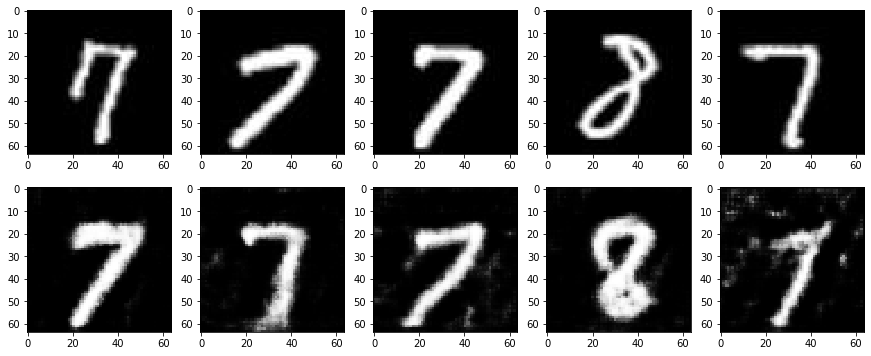

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)  
imges = next(batch_iterator)


fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

# AnoGANの

In [15]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    discrimination_loss = torch.abs(x_feature-G_feature)
    
    # discrimination_loss = discrimination_loss.view(
    #    discrimination_loss.size()[0], -1)
    
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


In [16]:

def make_test_datapath_list():

    train_img_list = list() 

    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


test_img_list = make_test_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


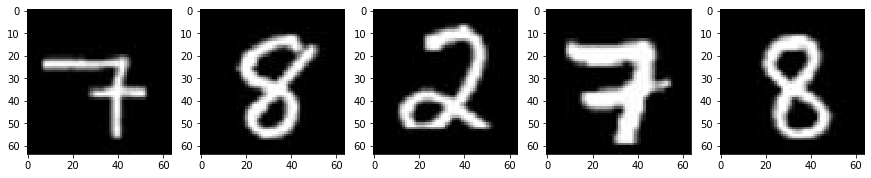

In [17]:
batch_iterator = iter(test_dataloader)
imges = next(batch_iterator)  

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [18]:
x = imges[0:5]
x = x.to(device)

z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

z.requires_grad = True

z_optimizer = torch.optim.Adam([z], lr=1e-3)


for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:7385 
epoch 1000 || loss_total:5278 
epoch 2000 || loss_total:4377 
epoch 3000 || loss_total:3462 
epoch 4000 || loss_total:3031 
epoch 5000 || loss_total:2547 


total loss： [431. 404. 804. 521. 389.]


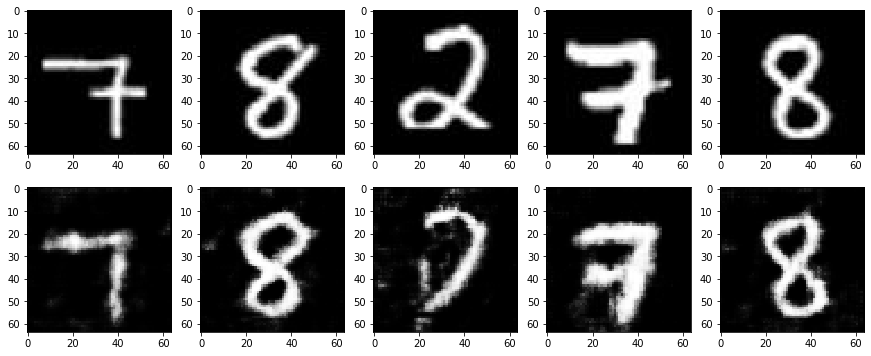

In [19]:
G_update.eval()
fake_img = G_update(z)

loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')
